# Análisis Exploratorio: San Francisco Bay Bike Rental

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
trip_meta = pd.read_csv('data/trip.csv')
weather_meta = pd.read_csv('data/weather.csv')

In [5]:
pd.options.mode.chained_assignment = None

### Convierto las fechas a datetime

In [6]:
trip_meta['start_date'] = pd.to_datetime(trip_meta['start_date'])

In [4]:
trip_meta['end_date'] = pd.to_datetime(trip_meta['end_date'])

In [7]:
import datetime
from datetime import date,time

In [8]:
#Saco los horarios de las fechas para analizar primero los viajes que son realizados durante el mismo dia
trip_meta['start_date2'] = trip_meta.start_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))
#trip_meta['end_date2'] = trip_meta.end_date.apply(lambda x: datetime.datetime(x.year, x.month, x.day,0,0))

In [12]:
trip_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 669959 entries, 0 to 669958
Data columns (total 14 columns):
id                    669959 non-null int64
duration              669959 non-null int64
start_date            669959 non-null datetime64[ns]
start_station_name    669959 non-null object
start_station_id      669959 non-null int64
end_date              669959 non-null datetime64[ns]
end_station_name      669959 non-null object
end_station_id        669959 non-null int64
bike_id               669959 non-null int64
subscription_type     669959 non-null object
zip_code              663340 non-null object
start_date2           669959 non-null datetime64[ns]
end_date2             669959 non-null datetime64[ns]
weekday               669959 non-null int64
dtypes: datetime64[ns](4), int64(6), object(4)
memory usage: 71.6+ MB


In [13]:
same_day = trip_meta.loc[trip_meta.start_date2 == trip_meta.end_date2,['id','duration','start_date2','end_date2','start_station_name','start_station_id','end_station_name','end_station_id']]

In [14]:
same_day.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 667860 entries, 0 to 669958
Data columns (total 8 columns):
id                    667860 non-null int64
duration              667860 non-null int64
start_date2           667860 non-null datetime64[ns]
end_date2             667860 non-null datetime64[ns]
start_station_name    667860 non-null object
start_station_id      667860 non-null int64
end_station_name      667860 non-null object
end_station_id        667860 non-null int64
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 45.9+ MB


### Son 2099 los viajes que duran mas de 1 dia

In [15]:
print len(trip_meta) - len(same_day)

2099


In [16]:
same_day.describe()

,id,duration,start_station_id,end_station_id
count,667860.000000,667860.000000,667860.000000,667860.00000
mean,460563.297664,896.212209,57.877699,57.85896
std,264565.577399,2190.634652,17.088461,17.17720
min,4069.000000,60.000000,2.000000,2.00000
25%,231317.750000,344.000000,50.000000,50.00000
50%,459550.000000,516.000000,62.000000,62.00000
75%,692844.250000,753.000000,70.000000,70.00000
max,913460.000000,83409.000000,84.000000,84.00000


### Filtro los viajes que duran menos de 5 minutos

In [17]:
trips_longer = same_day.loc[same_day.duration > 300,:]

In [18]:
trips_longer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 542405 entries, 100 to 669958
Data columns (total 8 columns):
id                    542405 non-null int64
duration              542405 non-null int64
start_date2           542405 non-null datetime64[ns]
end_date2             542405 non-null datetime64[ns]
start_station_name    542405 non-null object
start_station_id      542405 non-null int64
end_station_name      542405 non-null object
end_station_id        542405 non-null int64
dtypes: datetime64[ns](2), int64(4), object(2)
memory usage: 37.2+ MB


In [19]:
trips_longer.duration = trips_longer.duration.apply(lambda x: x/60.0)

/home/hernan/anaconda2/lib/python2.7/site-packages/pandas/core/generic.py:2773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


### Son 125455 los viajes que duran menos de 5 min

In [20]:
print len(same_day) - len(trips_longer)

125455


### Convierto a datetime la fecha en el DF weather

In [21]:
weather_meta['date'] = pd.to_datetime(weather_meta['date'])

# Analizo la cantidad de viajes segun la temperatura

In [348]:
temperatures = weather_meta[['date','max_temperature_f','mean_temperature_f','min_temperature_f']]

In [349]:
# Paso la temperatura a Celsius
temperatures.max_temperature_f = temperatures.max_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.mean_temperature_f = temperatures.mean_temperature_f.apply(lambda x: (x-32) / 1.8)
temperatures.min_temperature_f = temperatures.min_temperature_f.apply(lambda x: (x-32) / 1.8)

In [350]:
temperatures.rename(
    columns={'max_temperature_f':'max_temperature_c','mean_temperature_f':'mean_temperature_c','min_temperature_f':'min_temperature_c'},inplace=True)

In [351]:
temperatures_avg = temperatures.groupby('date').mean()
temperatures_avg = pd.DataFrame(temperatures_avg.to_records())

In [352]:
final = trips_longer[['id', 'duration', 'start_date2', 'start_station_name','end_station_name']]
final.rename(columns={'start_date2':'date','duration':'duration(min)'},inplace=True)

In [353]:
date_duration = final.loc[:,['duration(min)','date']].groupby('date').agg([np.size])
date_duration = pd.DataFrame(date_duration.to_records())
date_duration.columns=['date','# trips']

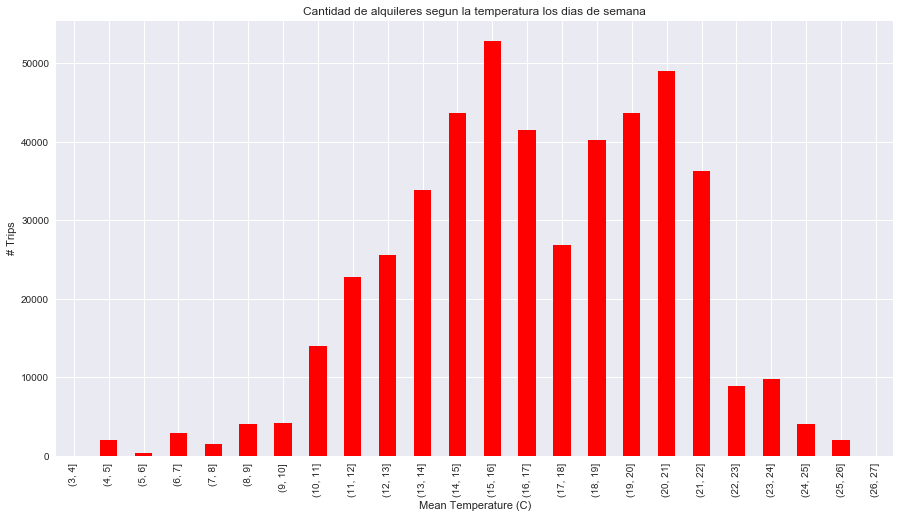

In [355]:
duration_temperature = pd.merge(date_duration,temperatures_avg,how='inner',on='date')
duration_temperature['weekday'] = duration_temperature.date.apply(lambda x: x.weekday())
duration_temperature_weekdays = duration_temperature\
                        .loc[(duration_temperature.weekday != 5) & (duration_temperature.weekday != 6),:]

duration_temperature_weekdays = duration_temperature_weekdays\
                        [['# trips','date','max_temperature_c','mean_temperature_c','min_temperature_c']]
    
trips_temperature = duration_temperature_weekdays.\
                groupby(pd.cut(duration_temperature_weekdays['mean_temperature_c'], np.arange(3,28))).sum()

f = plt.figure()
ax = trips_temperature['# trips'].plot.bar(figsize=(15,8),colormap='autumn',layout=('# trips','Mean Temperature (C)'), ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Mean Temperature (C)');
plt.title('Cantidad de alquileres segun la temperatura los dias de semana')
plt.show()

# ---------------------------------------------------------------------------------------------------------

# Alquiler de bicicletas por hora

In [31]:
trip_meta['hour'] = trip_meta.start_date.apply(lambda x: x.hour)

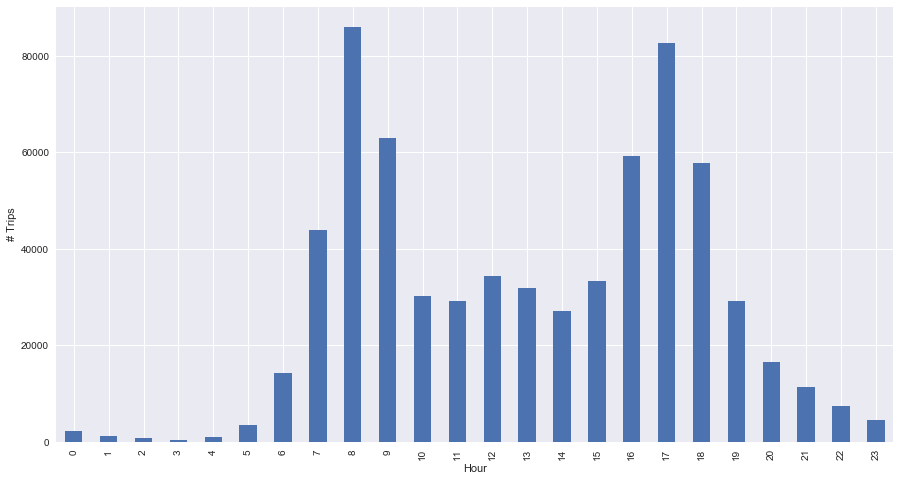

In [32]:
ax = trip_meta.groupby('hour').size().plot(kind='bar',figsize=(15,8))
ax.set_ylabel('# Trips')
ax.set_xlabel('Hour')

# ------------------------------------------------------------------------------------------------------

# Alquiler de bicicletas segun la lluvia, los dias de semana

In [325]:
precipitation = weather_meta[['date','precipitation_inches']]

In [326]:
precipitation.columns = ['date','inches']

In [327]:
precipitation = precipitation.loc[precipitation.inches != 'T',:]
precipitation.inches = pd.to_numeric(precipitation.inches)

In [328]:
precipitation = precipitation.groupby('date').mean()
precipitation = pd.DataFrame(precipitation.to_records())

In [329]:
precipitation_trips = pd.merge(date_duration,precipitation,how='inner',on='date')

In [332]:
precipitation_trips = precipitation_trips[['# trips','date','inches']]

In [333]:
precipitation_trips['weekday'] = precipitation_trips.date.apply(lambda x: x.weekday())
precipitation_trips = precipitation_trips.loc[(precipitation_trips.weekday != 5) & (precipitation_trips.weekday != 6),:]

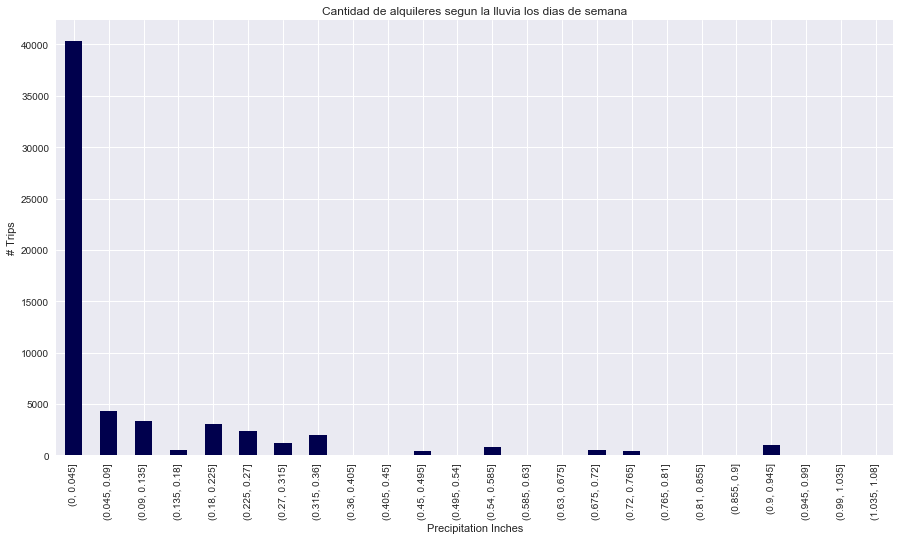

In [340]:
precipitation_trips_plot = precipitation_trips.\
                groupby(pd.cut(precipitation_trips['inches'], np.arange(0, 1.1, 0.045))).sum()

f = plt.figure()
ax = precipitation_trips_plot['# trips'].plot.bar(figsize=(15,8),colormap='seismic',ax=f.gca())
ax.set_ylabel('# Trips');
ax.set_xlabel('Precipitation Inches');
plt.title('Cantidad de alquileres segun la lluvia los dias de semana')
plt.show()

# Cantidad de alquileres por dia y la duracion promedio de los mismos.

In [292]:
dif_day_trips = final[['duration(min)','date']]
dif_day_trips['weekday'] = dif_day_trips.date.apply(lambda x: x.weekday())

In [14]:
def dia(x):
    if x==0:
        return 'Lunes'
    if x==1:
        return 'Martes'
    if x==2:
        return 'Miercoles'
    if x==3:
        return 'Jueves'
    if x==4:
        return 'Viernes'
    if x==5:
        return 'Sabado'
    if x==6:
        return 'Domingo'

In [294]:
dif_day_trips['weekday'] = dif_day_trips['weekday'].apply(dia)

In [296]:
dif_day_trips = dif_day_trips[['duration(min)','weekday']]

In [309]:
trips_by_day = dif_day_trips.groupby('weekday').agg([np.mean,np.size])
trips_by_day

duration(min)         
                   mean     size
weekday                         
Domingo       36.838362  33548.0
Jueves        14.532981  95503.0
Lunes         14.507142  92669.0
Martes        14.021545  97411.0
Miercoles     14.322358  96160.0
Sabado        34.903722  38940.0
Viernes       16.256842  88174.0

In [318]:
dif_day_trips_cant = pd.DataFrame(trips_by_day.to_records())
dif_day_trips_cant.columns = ['weekday','avg trip','trips']
dif_day_trips_avg = dif_day_trips_cant[['weekday','avg trip']]
dif_day_trips_cant = dif_day_trips_cant[['weekday','trips']]

## Cantidad de alquileres por dia

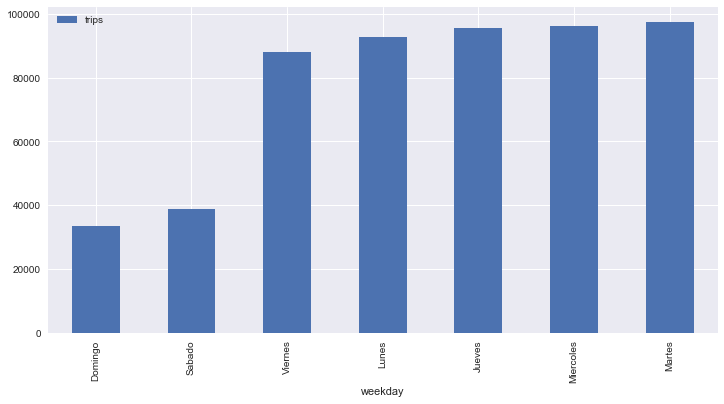

In [336]:
dif_day_trips_cant.sort_values('trips').plot(x='weekday',y='trips',kind='bar',figsize=(12,6))

## Duracion promedio de los alquileres por dia

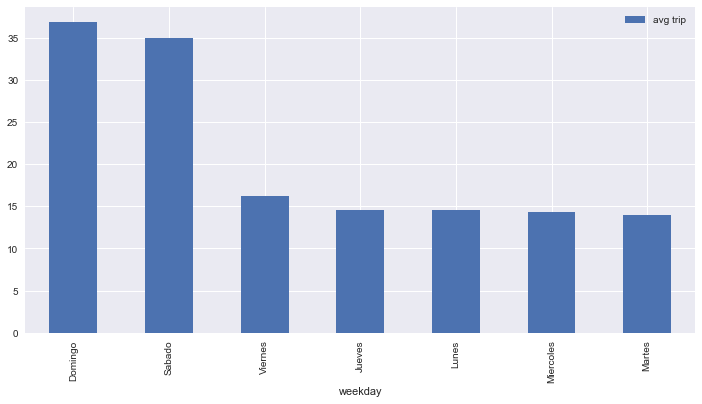

In [337]:
dif_day_trips_avg.sort_values('avg trip',ascending=False).plot(x='weekday',y='avg trip',kind='bar',figsize=(12,6))

# Estaciones más populares

In [23]:
station_stats = trip_meta[['start_station_name','end_station_name']]
station_stats.head()

,start_station_name,end_station_name
0,South Van Ness at Market,South Van Ness at Market
1,San Jose City Hall,San Jose City Hall
2,Mountain View City Hall,Mountain View City Hall
3,San Jose City Hall,San Jose City Hall
4,South Van Ness at Market,Market at 10th


In [40]:
station_stats['station_name'] = pd.concat([trip_meta['start_station_name'], trip_meta['end_station_name']])
station_stats.head()

San Francisco Caltrain (Townsend at 4th)    112271
San Francisco Caltrain 2 (330 Townsend)      68859
Harry Bridges Plaza (Ferry Building)         66127
Embarcadero at Sansome                       58509
2nd at Townsend                              54366
dtype: object

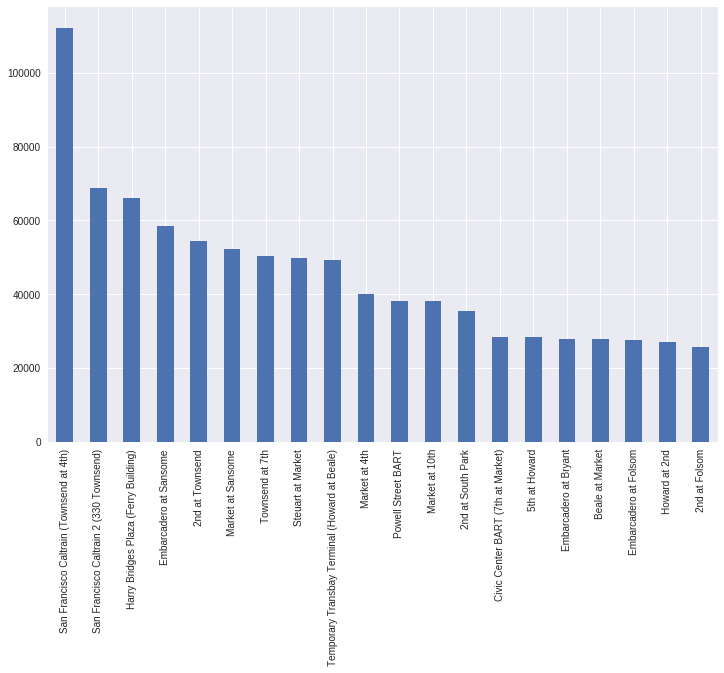

In [41]:
# TOP 20 Estaciones mas populares
station_stats = station_stats['station_name'].value_counts().head(20)
station_stats.plot(kind='bar',rot=90,figsize=(12,8));

## Estaciones más populares por día

In [30]:
popular_stations = trip_meta[['start_date','start_station_name','duration']]

In [31]:
# Filtro los viajes que duran menos de 5 minutos
popular_stations = popular_stations.loc[popular_stations.duration > 300,:]
popular_stations.head()

,start_date,start_station_name,duration
100,2013-08-29 17:22:00,Civic Center BART (7th at Market),305
101,2013-08-29 12:12:00,University and Emerson,307
102,2013-08-29 11:53:00,San Francisco City Hall,309
103,2013-08-29 11:58:00,Powell Street BART,309
104,2013-08-29 18:09:00,2nd at Townsend,309


In [32]:
popular_stations = popular_stations[['start_date','start_station_name']]
popular_stations.rename(columns={'start_date':'date','start_station_name':'station'},inplace=True)

In [33]:
popular_stations['weekday'] = popular_stations.date.apply(lambda x: x.weekday())

In [34]:
popular_stations['weekday'] = popular_stations['weekday'].apply(dia)
popular_stations = popular_stations[['station','weekday']]

In [36]:
print popular_stations.groupby('weekday')